In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import requests
import googleapiclient.discovery
import grpc
from tensorflow_serving.apis import prediction_service_pb2_grpc
from tensorflow_serving.apis.predict_pb2 import PredictRequest

In [2]:
mnist_ds = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_ds.load_data()
x_train = x_train[...,np.newaxis].astype(np.float32) / 255.
x_test = x_test[..., np.newaxis].astype(np.float32) / 255.

In [13]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28,1]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(10, activation='softmax'),
])
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(lr=1e-3),
             metrics=['accuracy'],
             )
model.fit(x_train, y_train, 
          epochs=5, 
          validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 17s 310us/sample - loss: 0.2125 - accuracy: 0.9343 - val_loss: 0.1075 - val_accuracy: 0.9705
Epoch 2/5
54000/54000 [==============================] - 20s 372us/sample - loss: 0.0940 - accuracy: 0.9708 - val_loss: 0.1060 - val_accuracy: 0.9713
Epoch 3/5
54000/54000 [==============================] - 20s 376us/sample - loss: 0.0677 - accuracy: 0.9776 - val_loss: 0.1077 - val_accuracy: 0.9725
Epoch 4/5
54000/54000 [==============================] - 20s 378us/sample - loss: 0.0533 - accuracy: 0.9829 - val_loss: 0.1113 - val_accuracy: 0.9742
Epoch 5/5
54000/54000 [==============================] - 20s 377us/sample - loss: 0.0432 - accuracy: 0.9858 - val_loss: 0.1090 - val_accuracy: 0.9793


In [15]:
model_version = '0001'
model_name = 'my_mnist_model'
model_path = os.path.join('models','19_lecture', 
                          model_name, model_version)
model_path

'models/19_lecture/my_mnist_model/0001'

In [28]:
saved_model = tf.saved_model.load(model_path)
y_pred = saved_model(x_train[:5], training=False)
y_pred

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[6.28731116e-17, 6.13076823e-14, 3.69153930e-10, 2.66730934e-01,
        2.75415840e-27, 7.33269095e-01, 1.07737022e-15, 7.13919958e-14,
        8.58869312e-12, 1.13344445e-10],
       [9.99999642e-01, 5.54814387e-13, 3.08294091e-07, 2.09596052e-09,
        1.77493027e-14, 3.68671170e-11, 6.03652239e-08, 4.34088793e-10,
        1.13593111e-11, 3.39790374e-09],
       [5.87161287e-13, 6.32793453e-05, 6.89156787e-10, 3.31477531e-06,
        9.71417189e-01, 4.02499682e-05, 9.98654137e-09, 2.84493323e-02,
        1.60386171e-05, 1.05526542e-05],
       [4.10605050e-10, 9.99998808e-01, 1.95728319e-07, 6.43016959e-11,
        7.16425347e-07, 3.95207467e-13, 5.65059288e-08, 2.10709203e-07,
        4.24188471e-08, 6.32469175e-13],
       [3.09338973e-15, 2.95136797e-11, 3.66005171e-10, 4.06747660e-07,
        5.31446894e-05, 1.07683764e-08, 1.15972390e-13, 1.88640463e-08,
        8.76461058e-07, 9.99945521e-01]], dtype=float32)>

In [16]:
os.makedirs('models/19_lecture', exist_ok=True)

In [18]:
tf.saved_model.save(model, model_path)

INFO:tensorflow:Assets written to: models/19_lecture/my_mnist_model/0001/assets


In [29]:
!saved_model_cli show --dir {model_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['flatten_1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_flatten_1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_3'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Defined Functions:
  Function Nam

In [3]:

input_data_json = json.dumps({
    "signature_name":"serving_default",
    "instances":x_train[:5].tolist(),
})

In [4]:

SERVER_URL = 'http://localhost:8501/v1/models/my_mnist_model:predict'
response = requests.post(SERVER_URL, input_data_json)
response.raise_for_status()
response = response.json()

ConnectionError: HTTPConnectionPool(host='localhost', port=8501): Max retries exceeded with url: /v1/models/my_mnist_model:predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f00da8ae890>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [41]:
response.keys()

dict_keys(['predictions'])

In [42]:
y_proba = np.array(response['predictions'])
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.27, 0.  , 0.73, 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.97, 0.  , 0.  , 0.03, 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]])

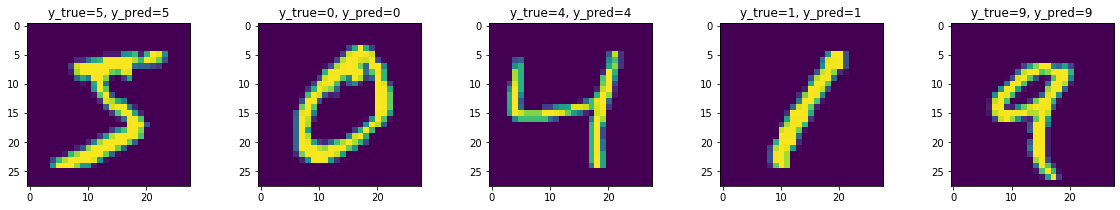

In [60]:
fig, axes = plt.subplots(1,5,figsize=(20,3))
y_pred = np.argmax(y_proba, axis=-1)
for ax,img,y_true,y_pred in zip(axes.ravel(), x_train[:5], y_train[:5], y_pred):
    ax.imshow(img[...,0])
    ax.set_title(f"y_true={y_true}, y_pred={y_pred}")
    


In [5]:
request = PredictRequest()
request.model_spec.name = model_name
request.model_spec.signature_name = 'serving_default'
input_name = model.input_names[0]
request.inputs[input_name].CopyFrom(tf.make_tensor_proto(x_train[:5]))
request

NameError: name 'model_name' is not defined

In [78]:

channel = grpc.insecure_channel('localhost:8500')
predict_service = prediction_service_pb2_grpc.PredictionServiceStub(channel)
response = predict_service.Predict(request, timeout=10.0)

In [80]:
response

outputs {
  key: "dense_3"
  value {
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: 5
      }
      dim {
        size: 10
      }
    }
    float_val: 6.287325720632679e-17
    float_val: 6.130781104139726e-14
    float_val: 3.691554839591049e-10
    float_val: 0.26673203706741333
    float_val: 2.7541961466423883e-27
    float_val: 0.7332680225372314
    float_val: 1.0773768868756477e-15
    float_val: 7.139229393207311e-14
    float_val: 8.58874603382187e-12
    float_val: 1.1334470167989608e-10
    float_val: 0.9999996423721313
    float_val: 5.548143867072086e-13
    float_val: 3.0829437491775025e-07
    float_val: 2.0959567414990943e-09
    float_val: 1.7749336546422738e-14
    float_val: 3.686711699812939e-11
    float_val: 6.036522393060295e-08
    float_val: 4.3408876493344906e-10
    float_val: 1.1359310193859162e-11
    float_val: 3.3979037361575593e-09
    float_val: 5.871579806561444e-13
    float_val: 6.327911978587508e-05
    float_val: 6.89158174971282

In [88]:
model_version = '0002'
model_name = 'my_mnist_model'
model_path = os.path.join('models','19_lecture',model_name, model_version)

In [89]:
tf.saved_model.save(model, model_path)

INFO:tensorflow:Assets written to: models/19_lecture/my_mnist_model/0002/assets


### Deploy the model to Google Cloud AI Platform

In [50]:
project_id = 'data-backup-276019'

In [52]:

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "models/19_lecture/data-backup-276019-7969a8b58d3a.json"
model_id = "my_mnist_model"
model_path = "projects/{}/models/{}".format(project_id, model_id)
model_path += "/versions/v0001/" # if you want to run a specific version
ml_resource = googleapiclient.discovery.build("ml", "v1").projects()

In [74]:
output_name = 'dense_3'

def predict(X):
    input_data_json = {"signature_name": "serving_default",
                       "instances": X.tolist()}
    request = ml_resource.predict(name=model_path, body=input_data_json)
    response = request.execute()
    if "error" in response:
        raise RuntimeError(response["error"])
        
    return np.array([pred[output_name] for pred in response["predictions"]])

In [75]:
y_probas = predict(x_test[:5])

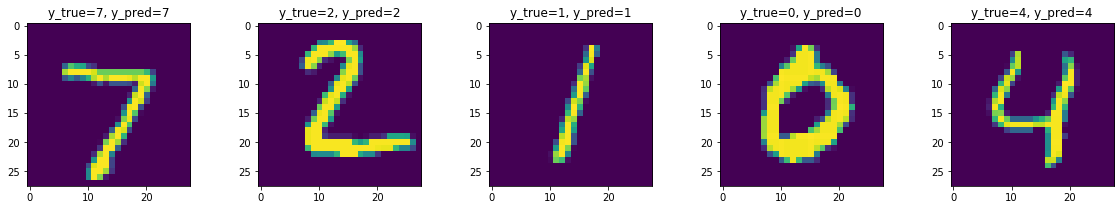

In [79]:
fig, axes = plt.subplots(1,5,figsize=(20,3))
y_pred = np.argmax(y_probas, axis=-1)
for ax,img,y_true,y_pred in zip(axes.ravel(), x_test[:5],
                                y_test[:5], y_pred):
    ax.imshow(img[...,0])
    ax.set_title(f"y_true={y_true}, y_pred={y_pred}")
    